In [36]:
#done by Abhishek Singh & Jessica Singh

In [37]:
#import individual packages:
import pandas as pd
import numpy as np
import sklearn
from sklearn import (cluster,
                     datasets,
                     decomposition,
                     discriminant_analysis,
                     dummy,
                     ensemble,
                     feature_selection as ftr_sel,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     pipeline,
                     preprocessing as skpre,
                     svm,
                     tree)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = sklearn.preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.items():
                output[colname] = sklearn.preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [39]:
#load your data:
df=pd.read_csv("NY Realstate Pricing.csv")
df.head()

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [40]:
#creating new meaningful features
df["total_revenue"]=df["days_occupied_in_2019"]*df["price"]

#cleansing data to fill missing data
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_features] = df[num_features].fillna(df[num_features].mean())

cat_features= df.select_dtypes(include=['object']).columns.tolist()
df[cat_features]=df[cat_features].fillna(df[cat_features].mode().iloc[0])


#encoding categorical values
encoder= MultiColumnLabelEncoder()
df[cat_features] = encoder.fit_transform(df[cat_features])


In [41]:
df.columns

Index(['F1', 'id', 'neighbourhood', 'latitude', 'longitude', 'room_type',
       'price', 'days_occupied_in_2019', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'availability_2020', 'total_revenue'],
      dtype='object')

In [42]:
#creating training data set
features=['neighbourhood', 'room_type', 'days_occupied_in_2019','minimum_nights', 'number_of_reviews']

X= df[features]
y= df['total_revenue']

X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.3, random_state=42)

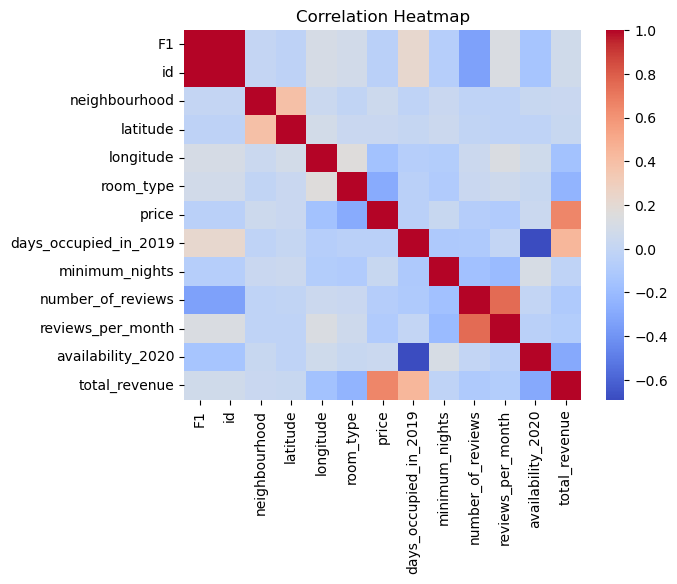

In [43]:
corr=df.corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [44]:
#lasso regression model
lasso=linear_model.LassoCV(cv=8)
lasso.fit(X_train, y_train)
y_pred_lasso= lasso.predict(X_test)

In [45]:
#regularized ridge regression model
ridge=linear_model.RidgeCV(cv=8)
ridge.fit(X_train, y_train)
y_pred_ridge=ridge.predict(X_test)

In [46]:
#regression tree model
tree= tree.DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree=tree.predict(X_test)

In [47]:
kf = skms.KFold(n_splits=10, shuffle=True, random_state=42)

# Train and evaluate models using cross-validation
lasso_scores = skms.cross_val_score(lasso, X, y, cv=kf, scoring='neg_mean_squared_error')
ridge_scores = skms.cross_val_score(ridge, X, y, cv=kf, scoring='neg_mean_squared_error')
tree_scores = skms.cross_val_score(tree, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate root mean squared error
lasso_rmse = np.sqrt(-lasso_scores)
ridge_rmse = np.sqrt(-ridge_scores)
tree_rmse = np.sqrt(-tree_scores)


# Display results
print("Lasso RMSE: %.2f" % lasso_rmse.mean())
print("Ridge RMSE: %.2f" % ridge_rmse.mean())
print("Tree RMSE: %.2f" % tree_rmse.mean())


Lasso RMSE: 31992.43
Ridge RMSE: 31901.51
Tree RMSE: 49296.44


In [48]:
def rms_error(actual, predicted):
    ' root-mean-squared-error function '
    # lesser values are better (a<b ... a better)
    mse = metrics.mean_squared_error(actual, predicted)    
    return np.sqrt(mse)
rms_scorer = metrics.make_scorer(rms_error)

In [49]:
def get_model_name(model):
    ' return name of model (class) as a string '
    return str(model.__class__).split('.')[-1][:-2]
def rdot(w,x):
    ' apply np.dot on swapped args '
    return np.dot(x,w)

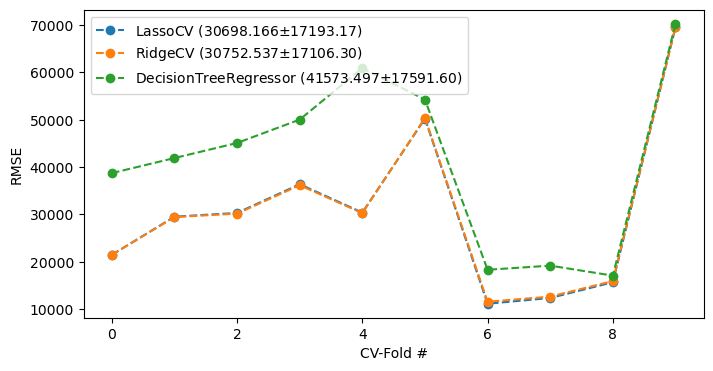

In [50]:
better_models = [lasso,ridge,tree]
scaler = skpre.StandardScaler()

fig, ax = plt.subplots(1, 1, figsize=(8,4))
for model in better_models:
    pipe = pipeline.make_pipeline(scaler, model)    
    cv_results = skms.cross_val_score(pipe, 
                                      X, y, 
                                      scoring = rms_scorer, 
                                      cv=10)

    my_lbl = "{:s} ({:5.3f}$\pm${:.2f})".format(get_model_name(model), 
                                                cv_results.mean(), 
                                                cv_results.std())
    ax.plot(cv_results, 'o--', label=my_lbl)
    ax.set_xlabel('CV-Fold #')
    ax.set_ylabel("RMSE")
    ax.legend()